## A NMC/Gr parameterisation example using PyBOP

This notebook introduces a synthetic re-parameterisation of the single-particle model with corrupted observations. To start, we import the PyBOP package for parameterisation and the PyBaMM package to generate the initial synethic data,

In [1]:
%pip install --upgrade pip ipywidgets pybamm -q
%pip install git+https://github.com/pybop-team/PyBOP.git@develop -q

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Next, we import the added packages plus any additional dependencies,

In [2]:
import pybop
import pybamm
import matplotlib.pyplot as plt
import numpy as np

## Generate Synthetic Data

We need to generate the synthetic data required for later reparameterisation. To do this we will run the PyBaMM forward model and store the generated data. This will be integrated into PyBOP in a future release for fast synthetic generation. For now, we define the PyBaMM model with a default parameter set,

In [3]:
synthetic_model = pybamm.lithium_ion.SPM()
params = synthetic_model.default_parameter_values

We can now modify individual parameters with the bespoke values and run the simulation.

In [4]:
params.update(
    {
        "Negative electrode active material volume fraction": 0.52,
        "Positive electrode active material volume fraction": 0.63,
    }
)

Define the experiment and run the forward model to capture the synthetic data.

In [5]:
experiment = pybamm.Experiment(
    [
        (
            "Discharge at 2C for 5 minutes (1 second period)",
            "Rest for 2 minutes (1 second period)",
            "Charge at 1C for 5 minutes (1 second period)",
            "Rest for 2 minutes (1 second period)",
        ),
    ]
    * 2
)
sim = pybamm.Simulation(synthetic_model, experiment=experiment, parameter_values=params)
synthetic_sol = sim.solve()

Plot the synthetic data,

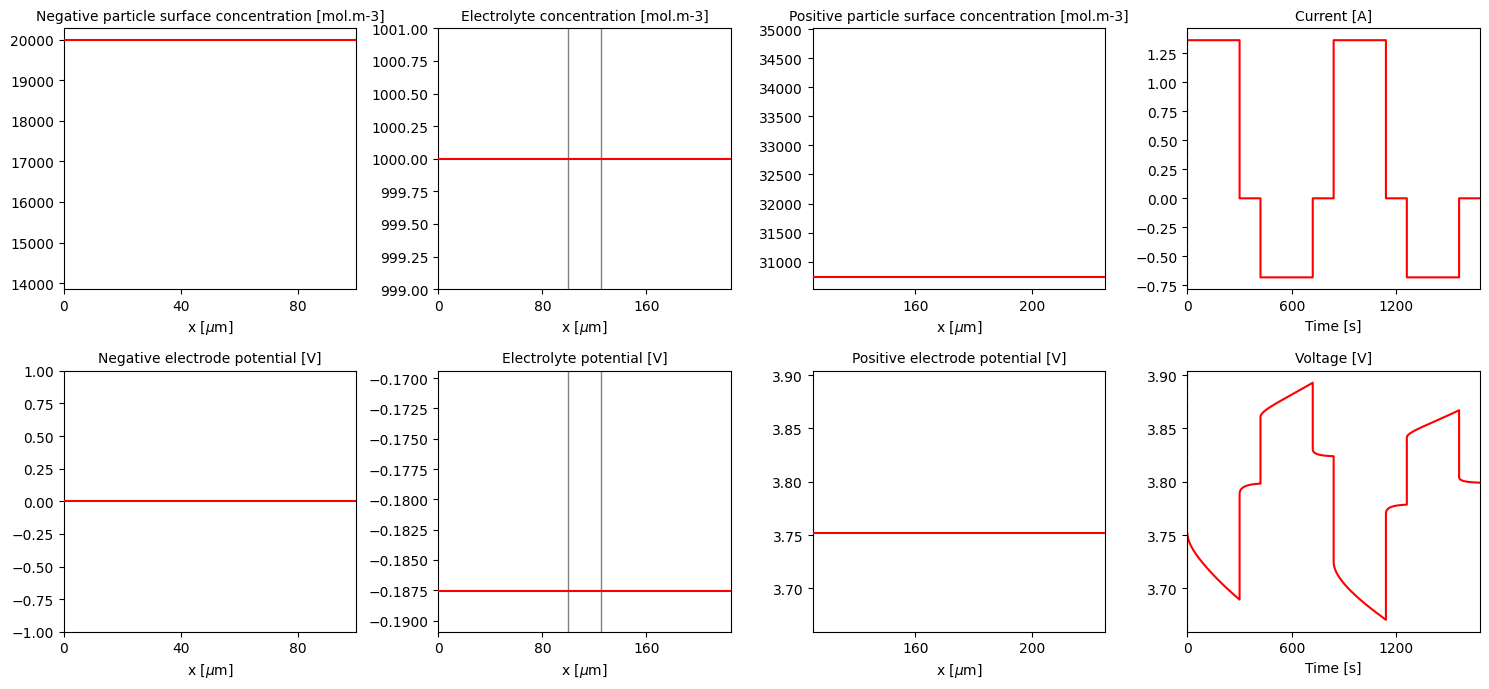

interactive(children=(FloatSlider(value=0.0, description='t', max=1680.0, step=16.8), Output()), _dom_classes=…

In [6]:
sim.plot()

Now, let's corrupt the synthetic data with 5mV of gaussian noise centered around zero,

In [7]:
corrupt_V = synthetic_sol["Terminal voltage [V]"].data
corrupt_V += np.random.normal(0, 0.005, len(corrupt_V))

## Identify the Parameters

Now, to blind fit the synthetic parameters we need to define the observation variables as well as update the forward model to be of PyBOP type (This composes PyBaMM's model class). For the observed voltage variable, we used the newly corrupted voltage array, 

In [8]:
model = pybop.lithium_ion.SPM()
observations = [
    pybop.Observed("Time [s]", synthetic_sol["Time [s]"].data),
    pybop.Observed("Current function [A]", synthetic_sol["Current [A]"].data),
    pybop.Observed("Voltage [V]", corrupt_V),
]

Next, we define the targetted forward model parameters for estimation. Furthermore, PyBOP provides functionality to define a prior for the parameters. The initial parameters values used in the estimiation will be randomly drawn from the prior distribution.

In [9]:
fit_params = [
    pybop.Parameter(
        "Negative electrode active material volume fraction",
        prior=pybop.Gaussian(0.5, 0.02),
        bounds=[0.375, 0.625],
    ),
    pybop.Parameter(
        "Positive electrode active material volume fraction",
        prior=pybop.Gaussian(0.65, 0.02),
        bounds=[0.525, 0.75],
    ),
]

We can now construct PyBOP's parameterisation class. This class provides the parameterisation methods needed to fit the forward model.

In [10]:
parameterisation = pybop.Parameterisation(
    model, observations=observations, fit_parameters=fit_params
)

Finally, we run the estimation algorithm. For this example, we use a root-mean square cost function with the BOBYQA algorithm implemented in NLOpt

In [11]:
results, last_optim, num_evals = parameterisation.rmse(
    signal="Voltage [V]", method="nlopt"
)

Last Voltage Values: 3.7996611982185766 3.7975057810794395
Last Voltage Values: 3.7998126133693533 3.7975057810794395
Last Voltage Values: 3.8031854726522285 3.7975057810794395
Last Voltage Values: 3.799468931833036 3.7975057810794395
Last Voltage Values: 3.795602883298669 3.7975057810794395
Last Voltage Values: 3.799699771891773 3.7975057810794395
Last Voltage Values: 3.7996774395763646 3.7975057810794395
Last Voltage Values: 3.799593518890104 3.7975057810794395
Last Voltage Values: 3.799509395374853 3.7975057810794395
Last Voltage Values: 3.799536439260354 3.7975057810794395
Last Voltage Values: 3.799500287332914 3.7975057810794395
Last Voltage Values: 3.7995753351359633 3.7975057810794395
Last Voltage Values: 3.7995384590593297 3.7975057810794395
Last Voltage Values: 3.7995486528904316 3.7975057810794395
Last Voltage Values: 3.799516169359653 3.7975057810794395
Last Voltage Values: 3.7995185726290273 3.7975057810794395
Last Voltage Values: 3.7995203555320374 3.7975057810794395
Last 

Let's view the identified parameters:

In [12]:
results

array([0.49301982, 0.63682677])

## Plotting

First, run SPM forward model with the estimated parameters,

In [13]:
params.update(
    {
        "Negative electrode active material volume fraction": results[0],
        "Positive electrode active material volume fraction": results[1],
    }
)
optsol = sim.solve()["Terminal voltage [V]"].data

Now, we plot the estimated forward model against the corrupted synthetic observation,

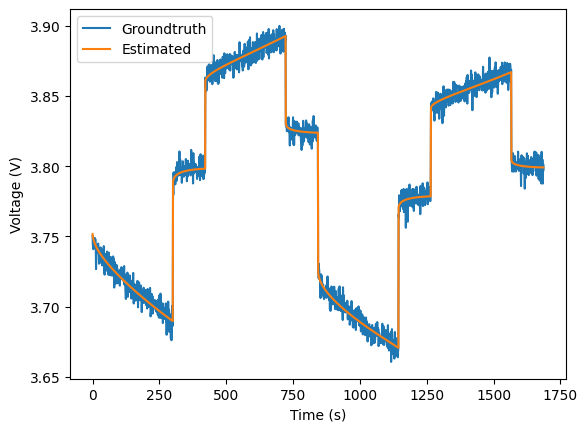

In [14]:
plt.plot(corrupt_V, label="Groundtruth")
plt.plot(optsol, label="Estimated")
plt.xlabel("Time (s)")
plt.ylabel("Voltage (V)")
plt.legend()